In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import processing
from utils import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (18,10)

In [3]:
kld = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])
stb = pd.read_csv('../data/processed/kolding_features.csv', index_col='Datetime', parse_dates=['Datetime'])

In [4]:
# Processing Parameters
split = 0.80 # split percentage for training data
steps = 1 # timesteps: 1 hour

lookback = 24 * 7 # the number of hours in the past the model is shown
horizon = 1 # the target hour in the future we want to predict 1 hour ahead

# Training parameters
batch_size = 256
epochs = 50
lr = 0.001

In [5]:
# Create Train, Val, and Test Sets
kld_train, kld_val, kld_test = processing.create_datasets(kld, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')
stb_train, stb_val, stb_test = processing.create_datasets(stb, split=split, steps=steps, lookback=lookback,
                                                          horizon=horizon, batch_size=batch_size, scaler='standard')

In [6]:
for batch in kld_train.take(1):
    inputs, targets = batch
    
print(f"Input Shape: {inputs.numpy().shape}")
print(f"Target Shape: {targets.numpy().shape}")

Input Shape: (256, 168, 7)
Target Shape: (256, 1)


In [7]:
# Stacked GRU
GRU_base = Sequential()

GRU_base.add(GRU(64, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
GRU_base.add(Dropout(0.25))
GRU_base.add(GRU(128, return_sequences=False))
GRU_base.add(Dropout(0.25))
GRU_base.add(Dense(1))

GRU_base.compile(optimizer=Adam(learning_rate=lr), loss="mse")

GRU_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 168, 64)           14016     
_________________________________________________________________
dropout (Dropout)            (None, 168, 64)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               74496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 88,641
Trainable params: 88,641
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Callbacks
ckpt_path = "../model/models/GRU_base.h5"
estp = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

ckpt = ModelCheckpoint(
    monitor='val_loss',
    filepath=ckpt_path,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [9]:
history = GRU_base.fit(
    kld_train,
    epochs=epochs,
    validation_data=kld_val,
    callbacks=[estp, ckpt]
)

Epoch 1/50
60/60 [==============================] - 66s 980ms/step - loss: 0.9666 - val_loss: 0.7700

Epoch 00001: val_loss improved from inf to 0.76999, saving model to ../model/models\GRU_base.h5
Epoch 2/50
60/60 [==============================] - 57s 954ms/step - loss: 0.5782 - val_loss: 0.7335

Epoch 00002: val_loss improved from 0.76999 to 0.73350, saving model to ../model/models\GRU_base.h5
Epoch 3/50
60/60 [==============================] - 59s 977ms/step - loss: 0.4957 - val_loss: 0.5735

Epoch 00003: val_loss improved from 0.73350 to 0.57353, saving model to ../model/models\GRU_base.h5
Epoch 4/50
60/60 [==============================] - 59s 990ms/step - loss: 0.4182 - val_loss: 0.5006

Epoch 00004: val_loss improved from 0.57353 to 0.50064, saving model to ../model/models\GRU_base.h5
Epoch 5/50
60/60 [==============================] - 58s 972ms/step - loss: 0.3695 - val_loss: 0.5133

Epoch 00005: val_loss did not improve from 0.50064
Epoch 6/50
60/60 [=========================

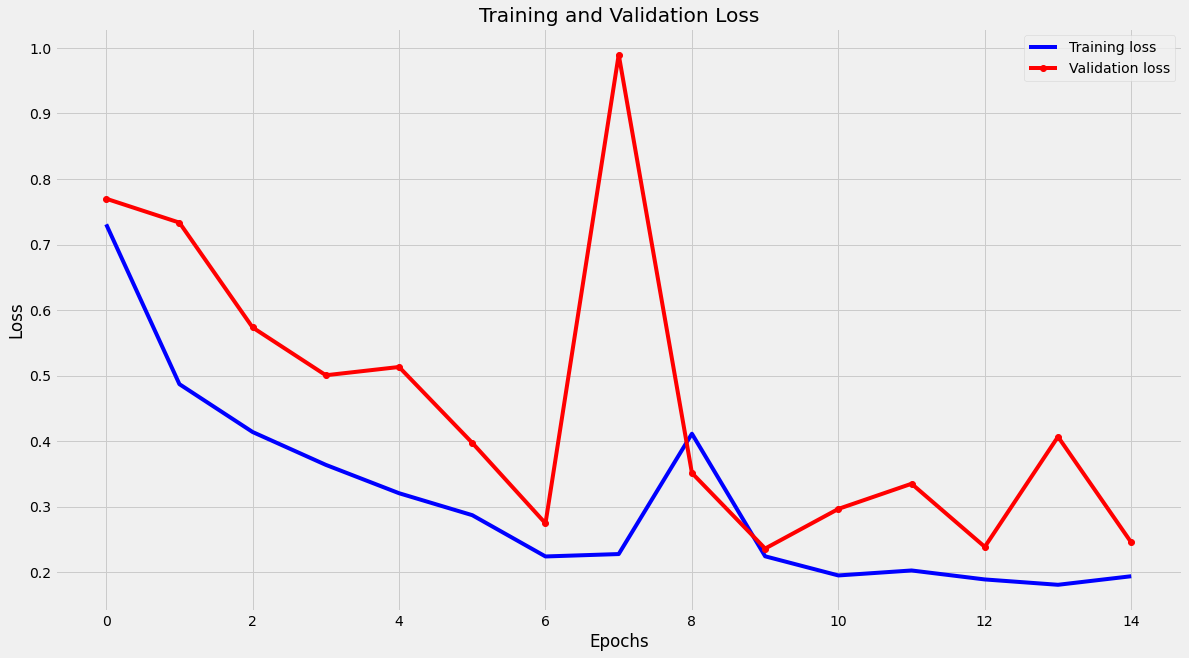

In [10]:
utils.plot_training(history, "Training and Validation Loss")

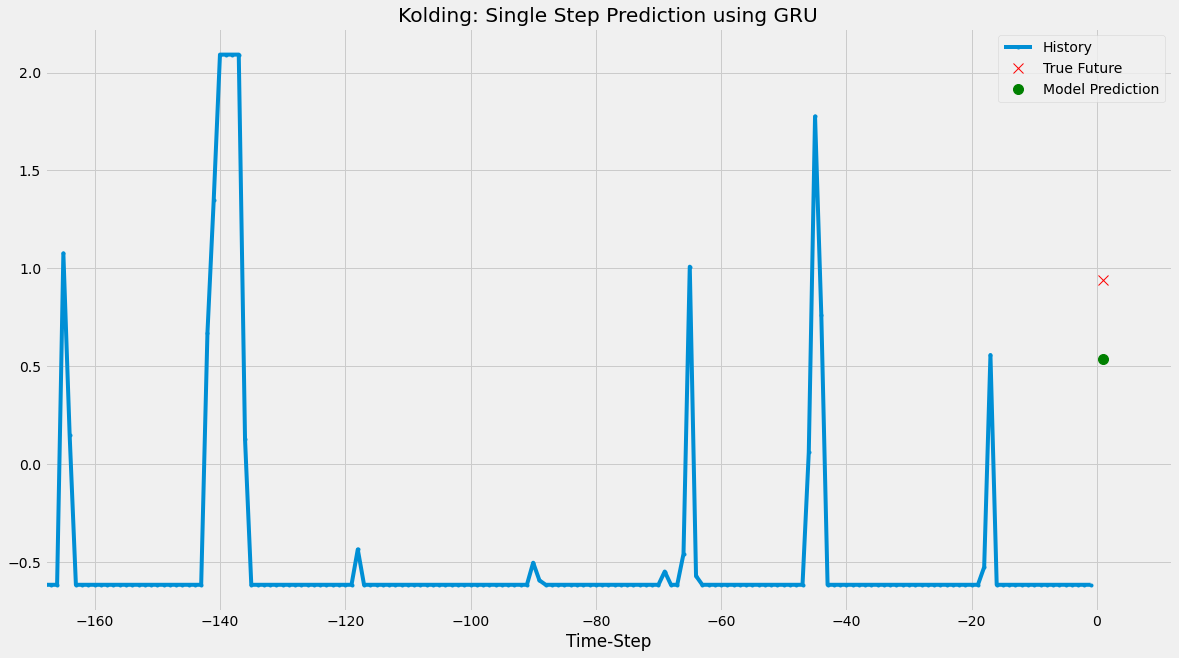

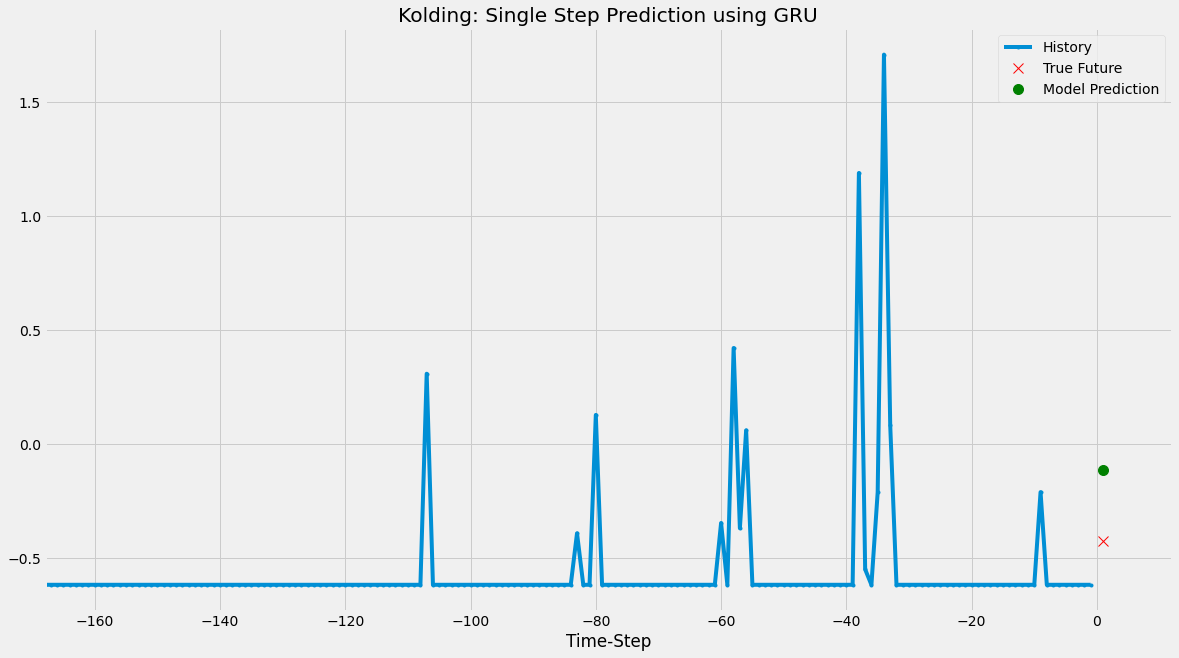

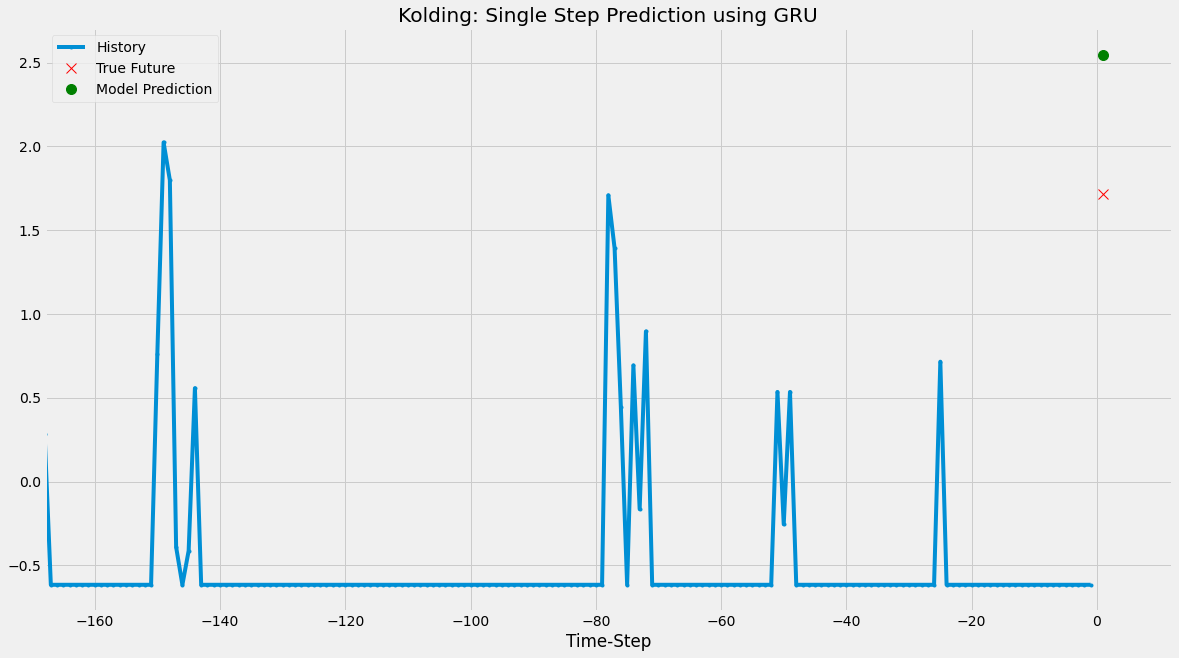

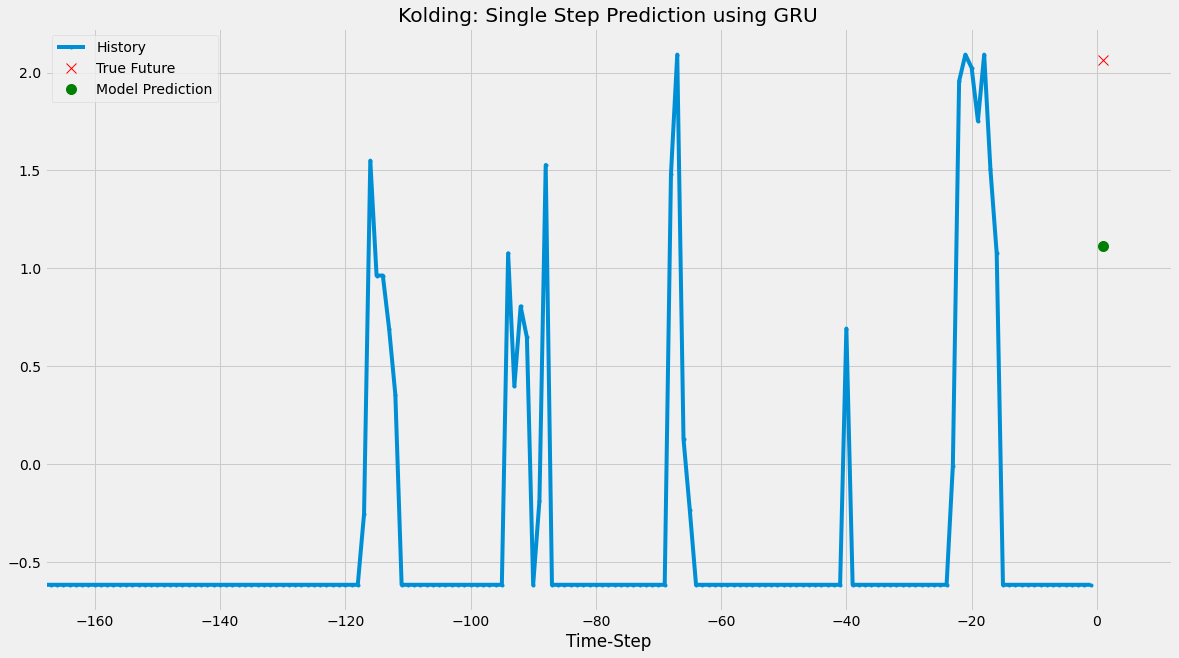

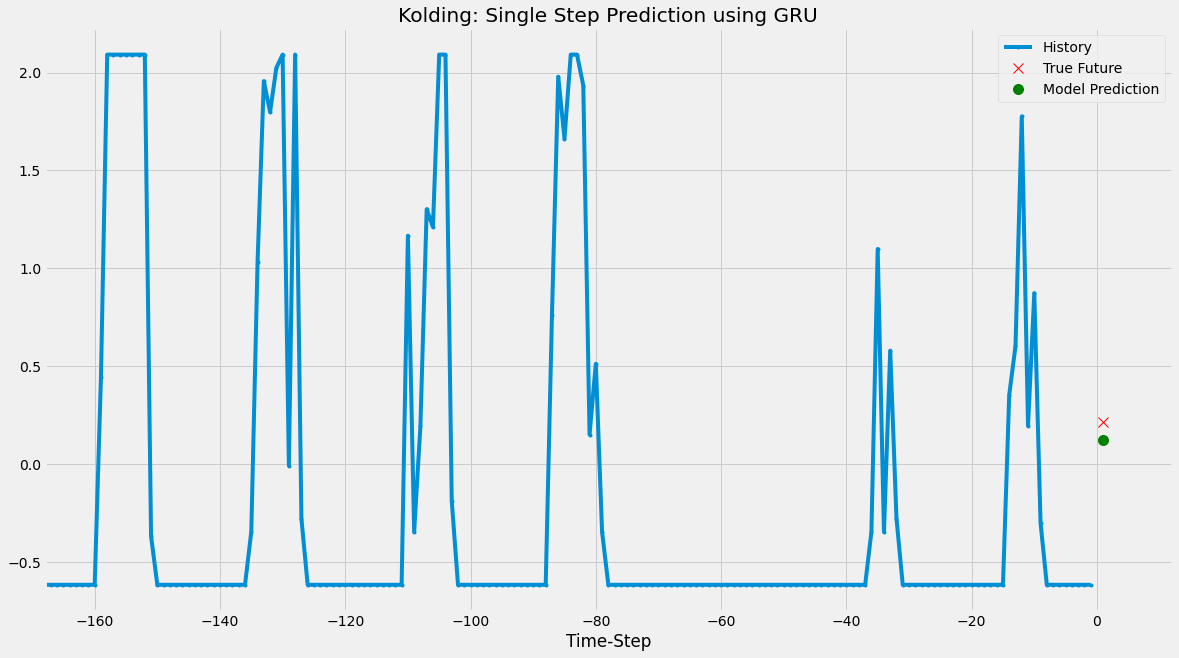

In [11]:
# Predictions
for x, y in kld_test.take(5):
    utils.plot_pred(
        [x[0][:, 1].numpy(), y[0].numpy(), GRU_base.predict(x)[0]],
        1,
        "Kolding: Single Step Prediction using GRU",
    )

